In [4]:
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import matplotlib

# Reading Data

In [5]:
remove_chars = [chr(x) for x in range(31)]
add_spaces = ["[", "]", "(", ")", "`", ":", ".", ";", "{", "}"]
def segmentWords(s): 
    # Remove non-printable characters, change remove ending apostrophe or apostrophe s, as those
    # make the dataset more sparse, and dont provide additional value regarding sentiment in the bag of words model.
    # (Most of the time its just making an extra word for a proper noun)
    for char in remove_chars:
        s = s.replace(char,"")
    for char in add_spaces:
        s = s.replace(char,char + " ")
    words = [word if not word.endswith("'s") else word[:-2] for word in s.split()]
    return [word if not word.endswith("'") else word[:-1] for word in words]

    

def readFile(fileName):
    # Function for reading file
    # input: filename as string
    # output: contents of file as list containing single words
    contents = []
    f = open(fileName)
    for line in f:
        contents.append(line)
    f.close()
    result = segmentWords('\n'.join(contents))
    return result

#### Create a Dataframe containing the counts of each word in a file

In [6]:
d = []
document_frequency_for_words = {}

for c in os.listdir("data_training"):
    directory = "data_training/" + c
    for file in os.listdir(directory):
        words = readFile(directory + "/" + file)
        e = {x:words.count(x) for x in words}
        for word in set(words):
            if word not in document_frequency_for_words:
                document_frequency_for_words[word] = 0
            document_frequency_for_words[word] += 1
        e['__FileID__'] = file
        e['is_positive'] = 1 if c == 'pos' else 0
        e['num_words'] = sum([1 for x in words if len(x) > 1]) #Exclude punctuation and empty strings
        d.append(e)

Create a dataframe from d - make sure to fill all the nan values with zeros.

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html


In [7]:
df = pd.DataFrame(data=d,index=None)
if '' in df.columns:
    df.drop('', inplace=True, axis=1)
df.fillna(value=0,axis=0,inplace=True)
df = df.astype(np.int32, errors='ignore') # Become slightly more memory efficient, because my computer is a potato.
del d

In [8]:
min_document_frequency = 5
bad_cols = []
for word in document_frequency_for_words.keys():
    if document_frequency_for_words[word] < min_document_frequency:
        bad_cols += [word]
print("Removing %s cols" % len(bad_cols))
df.drop(bad_cols, axis=1, inplace=True)

Removing 30750 cols


#### Split data into training and validation set 

* Sample 80% of your dataframe to be the training data

* Let the remaining 20% be the validation data (you can filter out the indicies of the original dataframe that weren't selected for the training data)

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html

In [9]:
traindf, validatedf = train_test_split(df, test_size=0.2)

* Split the dataframe for both training and validation data into x and y dataframes - where y contains the labels and x contains the words

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html

In [10]:
traindf_x = traindf.drop('is_positive', axis=1)
traindf_x.drop('__FileID__', inplace=True, axis=1)
traindf_y = pd.DataFrame(traindf['is_positive'])

validatedf_x = validatedf.drop('is_positive', axis=1)
validatedf_x.drop('__FileID__', inplace=True, axis=1)
validatedf_y = pd.DataFrame(validatedf['is_positive'])

# Logistic Regression

#### Basic Logistic Regression
* Use sklearn's linear_model.LogisticRegression() to create your model.
* Fit the data and labels with your model.
* Score your model with the same data and labels.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [11]:
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression()
trained_model = estimator.fit(traindf_x,traindf_y.values.ravel())

In [12]:
# make predictions
# summarize the fit of the model
accuracy_LR =  trained_model.score(validatedf_x, validatedf_y.values.ravel())
print("Accuracy from basic model: " ,accuracy_LR)

Accuracy from basic model:  0.853125


#### Changing Parameters

In [ ]:
## Skip running this, it takes too long ## 
## This is to show how we would go about tuning the hyperparameters using grid search and cross validation ##

if (False) {
    c_space = np.logspace(start = -2, stop = 3, base = 2, num =3)
    iter_space = np.logspace(start = 2, stop = 4, base = 10, num = 3)
    penalty_space = ["l2", "l1"]
    tol_space = np.logspace(start = -6, stop= -3, base = 10, num = 3)
    intercept_space = [True, False]

    param_grid = {'C': c_space, 'tol' : tol_space, 'fit_intercept' : intercept_space, 'max_iter' : iter_space, 'penalty' : penalty_space}

    logReg_model = LogisticRegression()

    logReg_CV = GridSearchCV(estimator = logReg_model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 3)
    trained_models = logReg_CV.fit(traindf_x, traindf_y.values.ravel())
}

Fitting 3 folds for each of 108 candidates, totalling 324 fits


#### Feature Selection
* In the backward stepsize selection method, you can remove coefficients and the corresponding x columns, where the coefficient is more than a particular amount away from the mean - you can choose how far from the mean is reasonable.

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.where.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.std.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.mean.html

In [18]:
## Here an attempt was made to manually remove the coefficients/features with low weights using the method described above.
## Consequently, although it's believed to have reduced overfitting, accuracy decreased as well.

from sklearn import preprocessing 
traindf_xNorm = preprocessing.normalize(traindf_x, norm="l2", axis=1, copy=True, return_norm=False)
normalizd_weights = preprocessing.normalize(trained_model.coef_, norm ="l2", axis = 1, copy=True, return_norm=False)
normalizd_weights.mean()
keep_indices = []

epsilon = 1500
weights_mean = abs(normalizd_weights.mean())
for i in range(len(normalizd_weights[0])):
    if ((abs(abs(normalizd_weights[0][i] - weights_mean) / weights_mean)) < epsilon):
        keep_indices.append(i)
        
traindf_xDropped = np.take(traindf_x,keep_indices, axis = 1)
trained_logReg = estimator.fit(traindf_xDropped, traindf_y.values.ravel())
validatedf_xDropped = np.take(validatedf_x, keep_indices, axis = 1)
validatedf_xKept = preprocessing.normalize(validatedf_xDropped, norm="l2", axis=1, copy=True, return_norm=False)
trained_logReg.score(validatedf_xDropped,validatedf_y)

0.84375

In [ ]:
## Takes a while to run ##

from sklearn.feature_selection import RFE
logReg_model = LogisticRegression()
rfe = RFE(logReg_model, step = 25, n_features_to_select = int(.8*traindf_x.shape[1] // 1), verbose = 1)
trained = rfe.fit(traindf_x, traindf_y.values.ravel())
validatedf_x.shape
print("Accuracy of the model after backwards stepwise ellimination: ", trained.score(validatedf_x, validatedf_y))

How did you select which features to remove? Why did that reduce overfitting?

** The features that were selected were the least informative 20% features of the model. This reduced overfitting by removing features our model may have been fitting to that which was not useful overall in predicting sentiment, because they had low weights **

# Single Decision Tree

#### Basic Decision Tree

* Initialize your model as a decision tree with sklearn.
* Fit the data and labels to the model.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


In [74]:
def most_important_features(dtc):
    lst = []
    for i in range(len(dtc.feature_importances_)):
        if dtc.feature_importances_[i] > 0:
            lst.append([dtc.feature_importances_[i], traindf_x.columns[i]])
    lst.sort(key=lambda x: x[0], reverse=True)
    return lst
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=13)
dt_clf.fit(traindf_x, traindf_y)
print("Decision tree score: ", dt_clf.score(validatedf_x, validatedf_y))

Decision tree score:  0.628125


#### Changing Parameters
* To test out which value is optimal for a particular parameter, you can either loop through various values or look into sklearn.model_selection.GridSearchCV

References:


http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [75]:
train_scores = []
valid_scores = []
x = [x for x in range(11, 20)]
num_trials = 3
for depth in x:
    training_score = 0
    validation_score = 0
    for i in range(num_trials):
        clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
        clf.fit(traindf_x, traindf_y)
        training_score += clf.score(traindf_x, traindf_y)
        validation_score += clf.score(validatedf_x, validatedf_y)
    train_scores += [training_score / num_trials]
    valid_scores += [validation_score / num_trials]
print("Highest validation score is: " + str(max(valid_scores)))

Highest validation score is: 0.654166666667


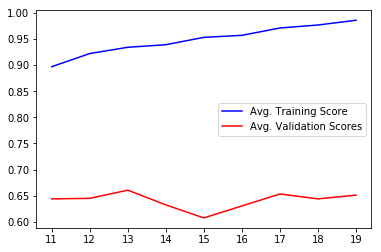

In [55]:
plt.plot(x, train_scores, color='b', label="Avg. Training Score")
plt.plot(x, valid_scores, color='r', label="Avg. Validation Scores")
plt.legend()
plt.show()

How did you choose which parameters to change and what value to give to them? Feel free to show a plot.

I chose to change the maximum depth parameter. I chose to vary this parameter, as lowering the maximum depth helps prevent the decision tree from overfitting. Thus it seemed sensible to try to find the optimal max depth to increase the validation scores. I have determined the value to give it from the above plot. The plot I made is a graph of the average decision tree accuracy on the training data and test data, with 5 samples per depth. The above plot indicates that the maximum validation score occurs at a maximum depth of 9. (*Please note that the exact peak changes depending on the test data / validation data split. On average 9 appears to be the peak of the validation series on the plot I made, however this can change between run-throughs. Other common peaks (that are typically shorter than the peaks at 9) occur at 5 and 16*

Why is a single decision tree so prone to overfitting?

A single decision tree can train to fit the training data exactly, and thus accounts for details present within the training data that aren't representative of the true underlying relationships.

As an interesting sidenote, lets see which words are the most indicative of the data being positive / negative. 

In [76]:
print(most_important_features(dt_clf)[:10])

[[0.068463869216651707, 'and'], [0.053373118210603136, 'bad'], [0.028911048189969056, 'the'], [0.022452116741190194, 'perfectly'], [0.021715127203035946, 'worst'], [0.019693301952424067, 'on'], [0.016800475021047236, 'in'], [0.01561732832931448, 'unfortunately'], [0.015108392744883544, 'excellent'], [0.01431524650098513, 'seriously']]


_I MADE AN ERROR EARLIER, THIS TEXT SECTION NEEDS TO BE REVISED_
These words really don't look they should be indicative of movie reviews in general. I wouldn't expect bacteria, or ancy to appear in the vast majority of reviews. This explains why the score on the validation data is so low (~70%). I suspect that there is some bias in the amount of reviews in the training set where it makes sense to have the words bacteria, and ancy. When you do multiple run-throughs with different validation / training splits, bacteria and ancy are consistenly in the top 10, indicating that there may indeed be some inherent bias in the given data. This could likely be fixed by getting more movie reviews, or using a model different than the bag of words model.

In [77]:
try: #Visualize our tree, if graphviz is on sys
    from sklearn.tree import export_graphviz
    def visualize_tree(tree, feature_names):
        import subprocess
        """Create tree png using graphviz.

        Args
        ----
        tree -- scikit-learn DecsisionTree.
        feature_names -- list of feature names.
        """
        with open("dt.dot", 'w') as f:
            export_graphviz(tree, out_file=f,
                            feature_names=feature_names)
        command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
        try:
            subprocess.check_call(command)
        except:
            exit("Could not run dot, ie graphviz, to "
                 "produce visualization. Run sudo-apt-get install graphviz to get it.")
    visualize_tree(dt_clf, traindf_x.columns)
    del dt_clf
except:
    print("You probably need to install graphviz on your system if you want a visualization of the decision tree.")

![Decision Tree Visualization](dt.png)

# Random Forest Classifier

#### Basic Random Forest

* Use sklearn's ensemble.RandomForestClassifier() to create your model.
* Fit the data and labels with your model.
* Score your model with the same data and labels.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


In [78]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=35, criterion='entropy')
rf_clf.fit(traindf_x, traindf['is_positive'])
print("Random forest score: ", rf_clf.score(validatedf_x, validatedf_y))
del rf_clf

Random forest score:  0.81875


#### Changing Parameters

In [79]:
parameters = {'criterion':['entropy'], 'n_estimators':[60], 'max_depth':[x for x in range(31,40)]}
rf_clf = RandomForestClassifier()
grd_src = GridSearchCV(rf_clf, parameters)
grd_src.fit(traindf_x, traindf['is_positive'])
print(grd_src.best_params_)
print(grd_src.score(validatedf_x, validatedf_y))

{'n_estimators': 60, 'max_depth': 38, 'criterion': 'entropy'}
0.79375


What parameters did you choose to change and why?

We chose to change the number of estimators and the maximum depth. The number of estimators is the number of trees in the forest, so it seemed like that would be a good thing to find the optimal value for. The conclusion reached was the more estimators the better, however we are bounded by computational resources. We chose to vary the max depth because that would have a large impact on the accuracy of the model. (Maximum depth directly controls how much the model is overfitting / underfitting)

How does a random forest classifier prevent overfitting better than a single decision tree?

Random forest trees help mitigate the problem of overfitting as they aggregate data into one final result. Random forest
classifiers limit overfitting without substantially increasing error due to bias as we are able to set a max depth on the models. Additionally, due to bagging, the features used in each individual tree are different, so when averaged, the result is improved.

In [82]:
df.head()

,!,"""",#1,#2,$10,$100,$2,$20,$200,$40,...,zingers,zoe,zombie,zombie-like,zombies,zone,zooms,zorro,zucker,zwick
0,0,24,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,42,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
